# Line Broadening Module

**NOTE**: The class structure might still be needed later, so all of the explanations are kept here. For now, the convolution seems to work suprisingly smoothly. Worth exploring.

### Caltech Summer 2019

This notebook explores broadening of spectral lines as expected from FU Ori accretion disks. Now, I'll take the original code I developed for this and turn it into a class that will handle finding multiple lines to broaden carefully and precisely. This might get tricky. Started on 3 July 2019. 

Things to make sure you understand:
1. The integral of $\phi(\lambda)$ should be normalized to 1. This way, the amplitude of the broadened line is consistent.
2. Wherever the profile $\phi(\lambda)$ goes to infinity, the next points beyond that should be zero (the function has vertical asymptotes). So make sure those aren't being integrated in the convolution.
3. Integrate in your convolution past that limit of the vertical asymptotes to get their contribution in there as well.

### Imports 

In [3]:
import numpy as np
import astropy.io.fits as fits
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Constants (astronomy is in cgs, right?)

In [4]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Toy spectrum

In [77]:
SPACE = 1e-8

In [78]:
x = np.arange(4000e-8, 4060e-8 + SPACE, SPACE)
x2 = np.arange(4000e-8,4060e-8 + SPACE, SPACE)
NOISE = 0.06*np.random.normal(0,1,len(x))

After giving each spectrum the same amount of noise, I will give different line widths, but the same line depths to demonstrate the difference.

In [79]:
MU = np.array([4010e-8, 4020e-8, 4035e-8, 4045e-8])
AMP = np.array([0.4, 0.6, 0.5, 0.7])

SIG_VALS = np.array([0.4])*1e-8

In [80]:
def gaussianFeature(x, mu, sig, amp):
    return -amp*np.exp(-0.5*((x-mu)/sig)**2)

def createToySpectra(x, mu, sig_arr, amp, noise):
    res = []
    for i in range(len(sig_arr)):
        spec = np.zeros(len(x))
        if noise:
            spec += NOISE
        for j in range(len(mu)):
#             spec += gaussianFeature(x, mu[j], sig_arr[i], amp[j]) + 5e5*(x-4020e-8) - 1e12*(x-4000e-8)**2
            spec += gaussianFeature(x, mu[j], sig_arr[i], amp[j]) 

        res.append(spec)

    return res
        

In [81]:
spectra = createToySpectra(x, MU, SIG_VALS, AMP, noise=False)
spectra2 = createToySpectra(x2, MU, SIG_VALS, AMP, noise=False)

In [82]:
wav, lum = x*1e8, spectra[0]
wav2, lum2 = x2*1e8, spectra2[0]

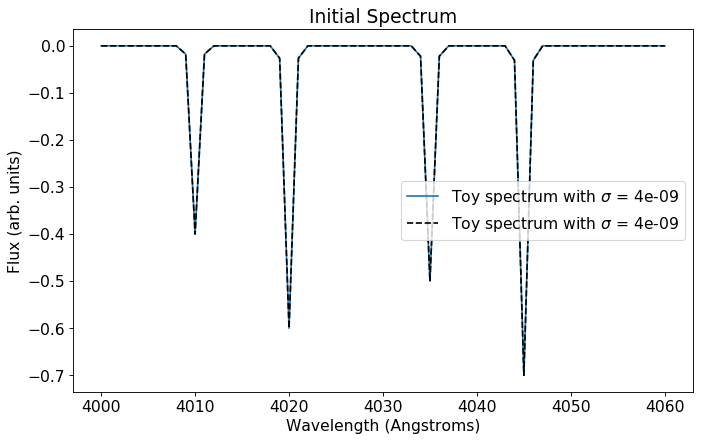

In [83]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(wav, lum,  label=r'Toy spectrum with $\sigma$ = ' + str(SIG_VALS[0]))
plt.plot(wav2, lum2, 'k--', label=r'Toy spectrum with $\sigma$ = ' + str(SIG_VALS[0]))


plt.title('Initial Spectrum')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (arb. units)')
plt.legend()
plt.show()

# Starting point for code needed to be transferred

If given a spectrum, $\texttt{setSpecHeight}$ shifts it along the vertical axis to any value.

In [84]:
def setSpecHeight(amps, val):
    max_amp = np.max(amps)
    return amps - max_amp + val

def dopplerProfileNorm(l, l_0, r, inc):
    l_out = np.zeros(len(l))
    v = (G*M_SUN/r)**(1/2)
    lmax = (l_0*v*np.sin(inc)/c_LIGHT)
    print(lmax)
    print(l_0)
    for i in range(len(l)):
#         if np.abs(l[i]-l_0) < lmax:
#         norm_fac = (1/(np.pi*lmax))
        l_out[i] = 1*(1 - ((l[i]-l_0)/lmax)**2)**(-1/2)
    return l_out

In [85]:
def instProfileNorm(waves, wave_0, width):
    waves = waves*1e-8
    wave_0 = wave_0*1e-8
    f_out = np.zeros(len(waves))
    wave_max = (wave_0*width/c_LIGHT)
    for i in range(len(waves)):
        if np.abs(waves[i]-wave_0) < wave_max:
            f_out[i] = (1/(np.pi*wave_max))*np.exp(-((waves[i]-wave_0)/wave_max)**2)
    return f_out 

In [86]:
from astropy.convolution import Trapezoid1DKernel, Gaussian1DKernel

In [1]:
from __future__ import print_function, division
import numpy as np
from PyAstronomy.pyaC import pyaErrors as PE
import six.moves as smo

class _Gdl:
  
  def __init__(self, vsini, epsilon):
    """
      Calculate the broadening profile.
      
      Parameters
      ----------
      vsini : float
          Projected rotation speed of the star [km/s]
      epsilon : float
          Linear limb-darkening coefficient
    """
    self.vc = vsini / 299792.458
    self.eps = epsilon
  
  def gdl(self, dl, refwvl, dwl):
    """
      Calculates the broadening profile.
      
      Parameters
      ----------
      dl : array
          'Delta wavelength': The distance to the reference point in
          wavelength space [A].
      refwvl : array
          The reference wavelength [A].
      dwl : float
          The wavelength bin size [A].
      
      Returns
      -------
      Broadening profile : array
          The broadening profile according to Gray. 
    """
    self.dlmax = self.vc * refwvl
    result = np.zeros(len(dl))
    x = dl/self.dlmax
    indi = np.where(np.abs(x) < 1.0)[0]
#     result[indi] = self.c1*np.sqrt(1. - x[indi]**2) + self.c2*(1. - x[indi]**2)
    result[indi] = (1/(np.pi*self.dlmax))*(1. - (x[indi])**2)**(-0.5)
    
    # Correct the normalization for numeric accuracy
    # The integral of the function is normalized, however, especially in the case
    # of mild broadening (compared to the wavelength resolution), the discrete
    # broadening profile may no longer be normalized, which leads to a shift of
    # the output spectrum, if not accounted for.
    result /= (np.sum(result) * dwl)
    return result
  

def rotBroad(wvl, flux, epsilon, vsini, edgeHandling="firstlast"):
  """
    Apply rotational broadening to a spectrum.
    
    This function applies rotational broadening to a given
    spectrum using the formulae given in Gray's "The Observation
    and Analysis of Stellar Photospheres". It allows for
    limb darkening parameterized by the linear limb-darkening law.
    
    The `edgeHandling` parameter determines how the effects at
    the edges of the input spectrum are handled. If the default
    option, "firstlast", is used, the input spectrum is internally
    extended on both sides; on the blue edge of the spectrum, the
    first flux value is used and on the red edge, the last value
    is used to extend the flux array. The extension is neglected
    in the return array. If "None" is specified, no special care
    will be taken to handle edge effects.
    
    .. note:: Currently, the wavelength array as to be regularly
              spaced.
    
    Parameters
    ----------
    wvl : array
        The wavelength array [A]. Note that a
        regularly spaced array is required.
    flux : array
        The flux array.
    vsini : float
        Projected rotational velocity [km/s].
    epsilon : float
        Linear limb-darkening coefficient (0-1).
    edgeHandling : string, {"firstlast", "None"}
        The method used to handle edge effects.
    
    Returns
    -------
    Broadened spectrum : array
        An array of the same size as the input flux array,
        which contains the broadened spectrum.
  """
  # Check whether wavelength array is evenly spaced
  sp = wvl[1::] - wvl[0:-1]
  if abs(max(sp) - min(sp)) > 1e-6:
    raise(PE.PyAValError("Input wavelength array is not evenly spaced.",
                         where="pyasl.rotBroad",
                         solution="Use evenly spaced input array."))
  if vsini <= 0.0:
    raise(PE.PyAValError("vsini must be positive.", where="pyasl.rotBroad"))
  if (epsilon < 0) or (epsilon > 1.0):
    raise(PE.PyAValError("Linear limb-darkening coefficient, epsilon, should be '0 < epsilon < 1'.",
                         where="pyasl.rotBroad",
                         solution="Adapt epsilon."))
  
  # Wavelength binsize
  dwl = wvl[1] - wvl[0]
  
  # Indices of the flux array to be returned
  validIndices = None
  
  if edgeHandling == "firstlast":
    # Number of bins additionally needed at the edges 
    binnu = int(np.floor(((vsini / 299792.458) * max(wvl)) / dwl)) + 1
    # Defined 'valid' indices to be returned
    validIndices = np.arange(len(flux)) + binnu
    # Adapt flux array
    front = np.ones(binnu) * flux[0]
    end = np.ones(binnu) * flux[-1]
    flux = np.concatenate( (front, flux, end) )
    # Adapt wavelength array
    front = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wvl = np.concatenate( (front, wvl, end) )
  elif edgeHandling == "None":
    validIndices = np.arange(len(flux))
  else:
    raise(PE.PyAValError("Edge handling method '" + str(edgeHandling) + "' currently not supported.",
                         where="pyasl.rotBroad",
                         solution="Choose ones of the valid edge handling methods"))
    
  
  result = np.zeros(len(flux))
  gdl = _Gdl(vsini, epsilon)
  
  for i in smo.range(len(flux)):
    dl = wvl[i] - wvl
    g = gdl.gdl(dl, wvl[i], dwl)
    result[i] = np.sum(flux * g)
  result *= dwl
  
  return result[validIndices]


In [88]:
1e-5*np.sin(np.radians(80))*np.sqrt(G*M_SUN/(10*R_SUN))

136.02558348686242

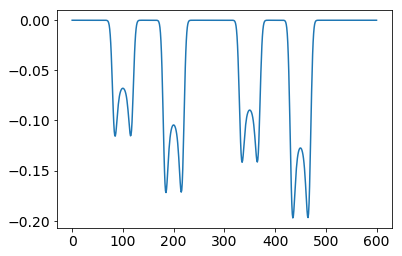

In [89]:
plt.plot(rotBroad(WAVE_TOY*1e8, AMPS_TOY[0], 0, 136))

In [90]:
WAVE_TOY = x
AMPS_TOY = spectra

WAVE_TOY2 = x2
AMPS_TOY2 = spectra2
DIST = 10
INC = 80

In [91]:
np.mean(WAVE_TOY)

4.030000000000006e-05

In [92]:
4030e-8

4.03e-05

In [93]:
dopp_arr = dopplerProfileNorm(WAVE_TOY, np.mean(WAVE_TOY), DIST*R_SUN, np.radians(INC)) 
gauss_arr = AMPS_TOY

dopp_arr2 = dopplerProfileNorm(WAVE_TOY2, np.mean(WAVE_TOY2), DIST*R_SUN, np.radians(INC)) 
gauss_arr2 = AMPS_TOY2

1.8285420023877193e-08
4.030000000000006e-05
1.8285420023877193e-08
4.030000000000006e-05


C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


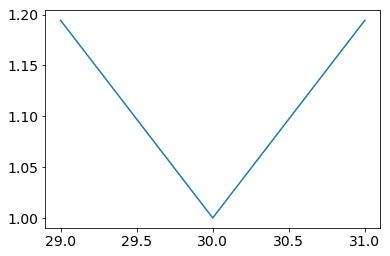

In [94]:
# plt.plot(convolve(np.ones(len(dopp_arr)), dopp_arr))
# plt.plot(convolve(np.ones(len(dopp_arr2)), dopp_arr2))
plt.plot(dopp_arr)
# plt.plot(dopp_arr2[:200])

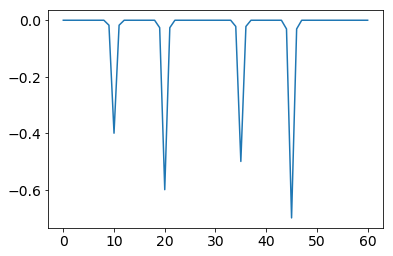

In [95]:
plt.plot(gauss_arr2[0][:200])

In [96]:
dopp_arr = np.nan_to_num(dopp_arr)

In [97]:
conv_arr = [convolve(gauss_arr[i], dopp_arr) for i in range(len(gauss_arr))]
conv_arr_2 = [convolve(gauss_arr[i]+100, dopp_arr) for i in range(len(gauss_arr))]

conv_arrTWO = [convolve(gauss_arr2[i], dopp_arr2) for i in range(len(gauss_arr2))]
conv_arr_2TWO = [convolve(gauss_arr2[i]+100, dopp_arr2) for i in range(len(gauss_arr2))]

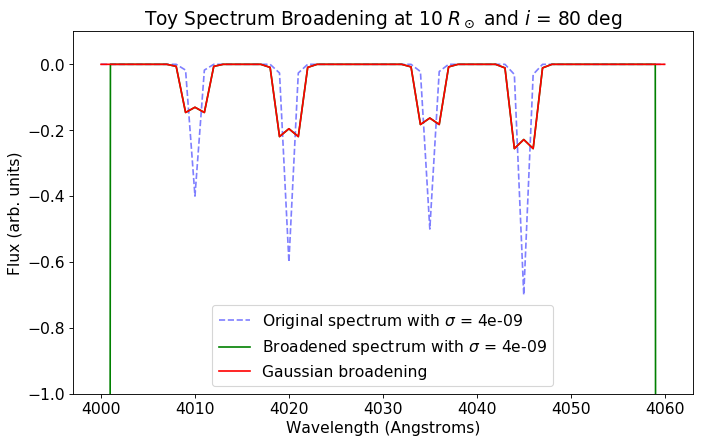

In [98]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(WAVE_TOY*1e8, AMPS_TOY[0], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
plt.plot(WAVE_TOY*1e8,conv_arr_2[0]-100, 'g-',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))

plt.plot(WAVE_TOY*1e8, rotBroad(WAVE_TOY*1e8, AMPS_TOY[0], 0, 136), 'r-', label='Gaussian broadening')
# plt.plot(WAVE_TOY2*1e8, AMPS_TOY2[0], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
# plt.plot(WAVE_TOY2*1e8,conv_arr_2TWO[0], 'r--',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))


plt.title(r'Toy Spectrum Broadening at ' + str(DIST) + ' $R_\odot$ and $i$ = ' + str(INC) + ' deg')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (arb. units)')
plt.ylim(-1,0.1)
plt.legend()
plt.show()

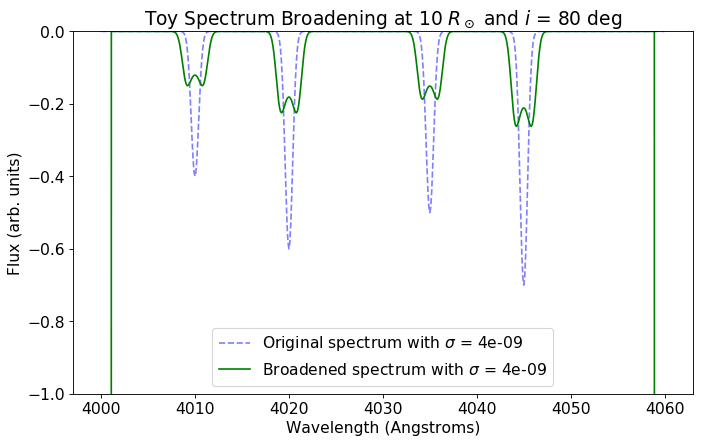

In [97]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(WAVE_TOY*1e8, AMPS_TOY[0], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
plt.plot(WAVE_TOY*1e8,conv_arr_2[0]-100, 'g-',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))


# plt.plot(WAVE_TOY2*1e8, AMPS_TOY2[0], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
# plt.plot(WAVE_TOY2*1e8,conv_arr_2TWO[0], 'r--',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))


plt.title(r'Toy Spectrum Broadening at ' + str(DIST) + ' $R_\odot$ and $i$ = ' + str(INC) + ' deg')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (arb. units)')
plt.ylim(-1,0)
plt.legend()
plt.show()